In [2]:
# import all modules here

import numpy as np
import os
import pickle

from data import load_data
from visualiser import visualize_images, plot_class_frequencies, convert_to_grayscale
from feature_ import l_features, extract_features, get_from_gpu
from LwP_ import LwP, LwP_updated
from sampler import sampler

import torch
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [ ]:
images, labels = load_data(1, 'train', 'one')
imgs = []
new_labels = []
for idx, image in enumerate(images):
    imgs.append(image)
    new_labels.append(labels[idx])
    s = sampler(image)
    # img1
    img2 = s.generate()

    # imgs.append(img1)
    imgs.append(img2)

    # new_labels.append(labels[idx])
    new_labels.append(labels[idx])

imgs = np.asanyarray(imgs)
new_labels = np.asanyarray(new_labels)

In [ ]:
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()
features = extract_features(imgs, batch_size=1)
model = LwP(10)
model.fit(features, new_labels)

X_eval, y_eval = load_data(1, 'eval', 'one')
X_eval = extract_features(X_eval)
y_pred = model.predict(X_eval)
print(np.mean(y_pred == y_eval))

In [ ]:
images, labels = load_data(1, "train", "one")

In [ ]:
#Number of unique labels
np.unique(labels)

In [ ]:
visualize_images(images, labels, 10)
plot_class_frequencies(images, labels)

In [ ]:
visualize_images(images, labels, 10)

In [ ]:
images = convert_to_grayscale(images)

In [ ]:
 # Flatten each 32x32 image to a 1024-dimensional vector
N = images.shape[0]
flattened_images = images.reshape(N, -1) 

In [ ]:
flattened_images.shape

## Generalized LwP

### Assuming Gaussian class conditional with Different Inverse Covariance Matrix

In [ ]:
# LwP model with euclidean distance on flattened_images
model = LwP(n_prototypes=10)
model.fit(flattened_images, labels)

# loading eval dataset
X_eval, y_eval = load_data(1, "eval", "one")
X_eval = convert_to_grayscale(X_eval)
X_eval = X_eval.reshape(X_eval.shape[0], -1)

# predicting on it
predictions = model.predict(X_eval, name = "euclidean")
accuracy = np.mean(predictions == np.asarray(y_eval))
print(f'Accuracy: {accuracy * 100:.2f}%')

In [ ]:
# Using LwP_updated
# LwP model with mahalanobis distance on flattened_images
model = LwP_updated(n_prototypes=10)
model.fit(flattened_images, labels)

# loading eval dataset
X_eval, y_eval = load_data(1, "eval", "one")
X_eval = convert_to_grayscale(X_eval)
X_eval = X_eval.reshape(X_eval.shape[0], -1)

# predicting on it

predictions = model.predict(X_eval)
accuracy = np.mean(predictions == np.asarray(y_eval))
print(f'Accuracy: {accuracy * 100:.2f}%')

## Trying new Approach by extracting features using Neural Network

In [ ]:
X_train, y_train = load_data(1, "train", "one")
X_train = [t.cpu().numpy() for t in extract_features(X_train)]
X_train = np.vstack(X_train)

In [ ]:
model = LwP_updated(n_prototypes=10)
model.fit(X_train, y_train)

In [ ]:
X_eval, y_eval = load_data(1, "eval", "one")
X_eval = get_from_gpu(extract_features(X_eval))
y_pred = model.predict(X_eval, name="euclidean")
acc = np.mean(y_eval == y_pred)
print(f'Accuracy on eval dataset is {acc * 100:.2f}%')

In [ ]:
"""
TODO
Train on D1

for i = 2 to 10
    update train on Di
        for j: i to 1
            predict Dj with ith model
"""

After changing model - found a sweet spot

# sufy @ Nov 7 midnight - 1.2

what I want to do here is on every new input dataset, learn the model which gives best accuracy on validation

what this runs into - computational issues. There are $10^{2500}$ possible models straight out of the bat. Even if I take it down to say, choose among the top 2 by the current model, it is still $2^{2500}$ (between about $10^{750}$ and $10^{833}$)

naive is subpar. need better update for these datasets

# Task 1.2

In [ ]:
res = [[0] * 10 for _ in range(10)]
model = LwP(10)

y = load_data(1, "train", "one", y_only = True)
X = l_features(1, "train", "one")
model.fit(X, y)
y_eval = load_data(1, "eval", "one", y_only = True)
X_eval = l_features(1, "eval", "one")
y_pred = model.predict(X_eval)
acc = np.mean(y_eval == y_pred)

res[0][0] = f'{acc*100:.2f}'
res[0][0]

In [ ]:
for i in range(2, 11):
    print(f'Running {i}')
    print(res[i - 2])
    X = l_features(i, 'train', 'one')
    y = model.predict(X)
    model.update(X, y)

    for j in range(1, i + 1):
        y = load_data(j, 'eval', 'one', y_only=True)
        X = l_features(j, 'eval', 'one')
        y_pred = model.predict(X)

        acc = np.mean(y_pred == y)
        res[i - 1][j - 1] = f'{acc * 100:.2f}'

In [ ]:
for i in res:
    for j in i:
        print(j, end = ' ')
    print()

# main event

In [ ]:
with open('model.pkl', 'wb') as f:
     pickle.dump(model, f)

In [9]:
model2 = pickle.load(open('model.pkl', 'rb'))

In [10]:
type(model2)

LwP_.LwP

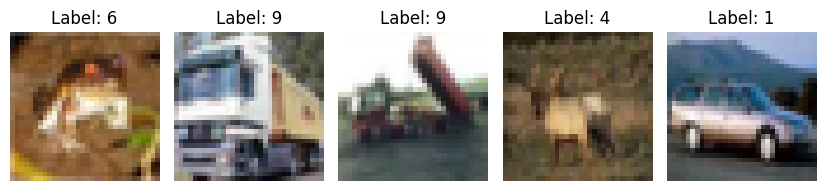

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.65808016..2.256082].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5024361..2.3145099].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48050445..2.333443].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46081603..1.9760383].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6161454..2.1356997].


torch.Size([10, 3, 32, 32]) torch.Size([10])
hmmmm
Bye


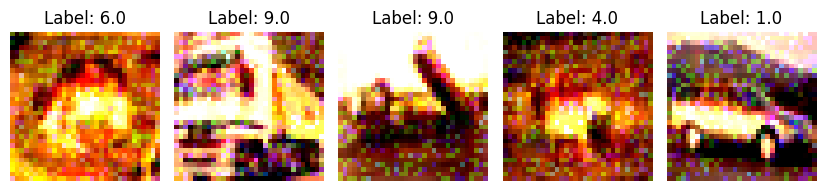

array([[[-0.12866257, -0.17158414,  0.24362241],
        [ 0.05387272,  0.33261212,  0.22330438],
        [-0.00341484, -0.12072949,  0.2538114 ],
        ...,
        [-0.45741519, -0.09432456,  0.25147707],
        [-0.49888202, -0.06235024,  0.28144165],
        [-0.48327407, -0.05204889,  0.29943869]],

       [[ 0.21131543,  0.35540942, -0.05122704],
        [ 0.33619985,  0.51772869,  0.15113114],
        [ 0.34387815,  0.46815533,  0.17221923],
        ...,
        [-0.32685635,  0.03997084,  0.3411206 ],
        [-0.3610771 ,  0.0402648 ,  0.35140884],
        [-0.27860722,  0.02718802,  0.35716364]],

       [[ 0.20343074, -0.10394917,  0.26254228],
        [ 0.33591733,  0.45254886,  0.24718115],
        [ 0.23036501,  0.27717786,  0.42650259],
        ...,
        [-0.29851637,  0.0210758 , -0.12282636],
        [-0.30922309,  0.04552438,  0.35474747],
        [-0.21872911,  0.09462492,  0.33331625]],

       ...,

       [[-0.73117514, -0.4619294 ,  0.33280651],
        [-0

In [11]:
images1, labels1 = load_data(1, 'train', 'one')
visualize_images(images1, labels1, 5)
images = (torch.tensor(images1[:10]).float() / 255.0).cuda().permute(0, 3, 1, 2)
labels = (torch.tensor(labels1[:10]).float()).cuda()
print(images.shape, labels.shape)

s = sampler(noise=1.0)
print('hmmmm')
new_images, new_labels = s.generate(images, labels, 1)
print("Bye")
new_images = new_images.permute(0, 2, 3, 1).cpu().detach().numpy()
new_labels = new_labels.cpu().detach().numpy()
visualize_images(new_images, new_labels, 5)
# visualize_images(images.cpu(), labels.cpu(), 10)

images1[0] / 255.0 - new_images[0]

In [12]:
for i in range(1, 11): # for part two
    print(f'Running {i}')

    X = l_features(i, 'train', 'two')
    im = load_data(i, 'train', 'two')

    X_opt, y_opt = model2.top_k(X, 50, indices=True)
    X_new = np.asanyarray([im[i] for i in X_opt])
    X_new = ((torch.tensor(X_new)).float() / 255.0).permute(0, 3, 1, 2).cuda()
    X_gen, y_gen = sampler().generate(X_new, torch.tensor(y_opt), 1)
    X_gen = extract_features(X_gen)

    # X_new, y_new = model2.top_k(X_new, 10*(i - 1))
    if (i != 1): model2.update(X_gen, y_gen, True)

    for j in range(1, 11):
        y = load_data(j, 'eval', 'one', y_only=True)
        X = l_features(j, 'eval', 'one')
        y_pred = model2.predict(X, 'euc')

        acc = np.mean(y_pred == y)
        # res[i - 1][j - 1] = f'{acc * 100:.2f}'
        print(f'{acc * 100:.2f}', end=' ')

    for j in range(1, i + 1):
        y = load_data(j, 'eval', 'two', y_only=True)
        X = l_features(j, 'eval', 'two')
        y_pred = model2.predict(X, 'euc')

        acc = np.mean(y_pred == y)
        # res[i - 1][j - 1] = f'{acc * 100:.2f}'
        print(f'{acc * 100:.2f}', end=' ')

    print()

Running 1
80.16 81.00 80.96 81.32 81.96 81.52 81.00 81.48 80.84 81.80 66.16 
Running 2
80.28 80.76 80.96 81.12 

KeyboardInterrupt: 